<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/See_Food_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# See Food v2

In [1]:
!pip install albumentations

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from sklearn.preprocessing import LabelBinarizer

import joblib
import argparse
import albumentations

from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
else:
  print(device)

Tesla T4


In [4]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [5]:
def mount_gdrive():
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Kaggle/See_Food')
    !ls

colab=False

if colab:
    mount_gdrive()

In [6]:
# unzip data file

zip=False

if zip:
  %cd data
  !unzip final-project-food-recognition-challenge.zip
  %cd ..

In [7]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/train_labels.csv')
path = 'data/train_set/train_set/'

X = path+df.img_name.values
y = df.label.values
print(X)

['data/train_set/train_set/train_1.jpg'
 'data/train_set/train_set/train_2.jpg'
 'data/train_set/train_set/train_3.jpg' ...
 'data/train_set/train_set/train_30610.jpg'
 'data/train_set/train_set/train_30611.jpg'
 'data/train_set/train_set/train_30612.jpg']


In [8]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))

In [9]:
# image dataset module
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=30,
                    p=1.0
                ),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [10]:
train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
test_data = NaturalImageDataset(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=1024, shuffle=True)
testloader = DataLoader(test_data, batch_size=1024, shuffle=False)

In [11]:
lb = LabelBinarizer()
lb.fit_transform(y)
lb.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [12]:
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Linear(2048, len(lb.classes_))
    return model
model = model(pretrained=True, requires_grad=False).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [13]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

In [14]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        ## I dont know why this works but needed to subtract 1 from target
        loss = criterion(outputs, target-1)
        
        
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [15]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)

            ## I dont know why this works but needed to subtract 1 from target
            loss = criterion(outputs, target-1)            
                        
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [20]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 of 10
Training


23it [02:59,  7.79s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.60
Validating


8it [00:50,  6.30s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.72
Epoch 2 of 10
Training


23it [02:59,  7.80s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.63
Validating


8it [00:50,  6.29s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.71
Epoch 3 of 10
Training


23it [03:01,  7.87s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.64
Validating


8it [00:50,  6.33s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.86
Epoch 4 of 10
Training


23it [03:00,  7.84s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.71
Validating


8it [00:50,  6.34s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.86
Epoch 5 of 10
Training


23it [03:01,  7.90s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.73
Validating


8it [00:51,  6.39s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.86
Epoch 6 of 10
Training


23it [03:00,  7.86s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.84
Validating


8it [00:50,  6.35s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 0.89
Epoch 7 of 10
Training


23it [02:58,  7.74s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.80
Validating


8it [00:49,  6.25s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0045, Val Acc: 0.93
Epoch 8 of 10
Training


23it [03:00,  7.84s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.88
Validating


8it [00:50,  6.35s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0045, Val Acc: 0.93
Epoch 9 of 10
Training


23it [03:00,  7.87s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.85
Validating


8it [00:51,  6.38s/it]
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0045, Val Acc: 0.94
Epoch 10 of 10
Training


23it [03:02,  7.91s/it]
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.81
Validating


8it [00:49,  6.24s/it]

Val Loss: 0.0045, Val Acc: 0.90
38.494 minutes


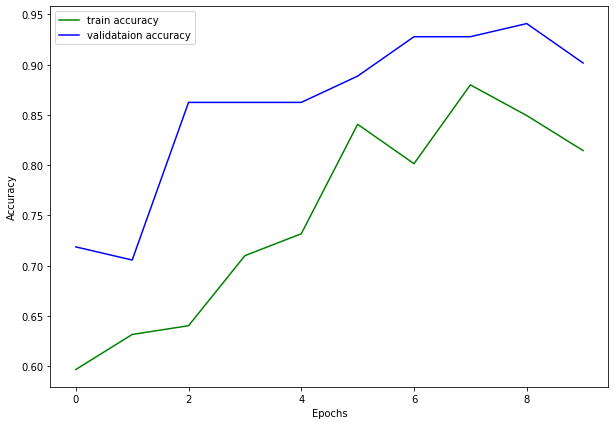

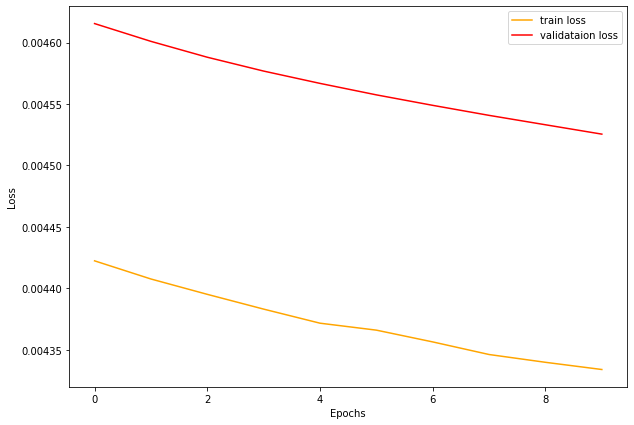

In [21]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()

In [22]:
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'outputs/model.pth')

Saving model...
